## Smart Analytics for DC Demographic and Crime Data
This notebook demonstrates the baseline smart analytics capabilities for demographic and crime datasets in the DC area, aggregated into voting precint features. 

The notebook first imports both datasets from ArcGIS online and then combines then into a single pandas spatial data frame. The pairwise mutual information is computed for each attribute in the dataframe and the results of the correlation analysis is visualized in several ways (as a dense/sparse graph, tree, and scatter plots.).

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Import AcrGIS python API
from arcgis import GIS
from arcgis.features import SpatialDataFrame, GeoAccessor
from arcgis.features.analysis import join_features

In [7]:
# Connect to GIS 
# gis = GIS("https://dcdev.maps.arcgis.com", client_id='5cgF3rTvZpFphAIo')
gis = GIS(username='gflaspohler')

Enter password: ········


#### Get data from ArcGIS online content
In this demonstration, I select three feataure collections to import from ArcGIS online. The first has the voting boundaries for the DC area. The seconds is an aggregration of crime indicents by voting precint in the DC area. The thrid is the same voting precints enriched by demographic information. 

In [8]:
# Get data for analysis from my content and select first serach result
dc_voting_boundaries = gis.content.search("Basemap_of_DC", outside_org=True)[0]
crime_raw_vote_block = gis.content.search('Aggregation_of_MPD___Crime_Incidents___2017_to_Voting_Precinct__2012_Full_Extent', outside_org=True)[3]
enriched_vote_block = gis.content.search('Enriched_Voting_Precinct__2012_crime_info', outside_org=True)[0]

#### Combining data into a single spatial dataframe
An efficent way to perform large data operations in Python is using pandas spatial dataframes. The ArcGIS API for python allows feature layers to be converted directly into Pandas dataframes. We first perform a spatial join on the two feataure layers and then convert the resulting layer into a Pandas data frame.  

In [9]:
full_data_layer = gis.content.search('join_demo_crime_dc_voting_precint', outside_org=True)[0]
full_data_features = full_data_layer.layers[0].query()
full_data_df = full_data_features.sdf

In [10]:
# View the resulting dataframe
full_data_df.head()

,ACSBPOVMCF,ACSHHBPOV,AVGHHSZ_CY,AnalysisArea,BACHDEG_CY,DIVINDX_CY,DIVORCD_CY,ENRICH_FID,GRADDEG_CY,HSGRAD_CY,...,TOTPOP_CY,UNEMP_CY,VACANT_CY,WEB_URL,WEB_URL_1,X8002_X,aggregationMethod,apportionmentConfidence,populationToPolygonSizeRating,sourceCountry
0,5,834,1.86,0.352471,1721,67.8,977,13,2767,1112,...,10742,376,334,http://www.dcboee.org/voter_info/find_pollingp...,http://www.dcboee.org/voter_info/find_pollingp...,17389444,BlockApportionment:US.BlockGroups,2.576,2.191,US
1,8,573,1.85,0.617159,1209,40.8,474,34,2409,79,...,6165,117,267,http://www.dcboee.org/voter_info/find_pollingp...,http://www.dcboee.org/voter_info/find_pollingp...,20143871,BlockApportionment:US.BlockGroups,2.576,2.191,US
2,0,618,2.29,0.500712,101,13.7,287,135,75,1029,...,3954,183,49,http://www.dcboee.org/voter_info/find_pollingp...,http://www.dcboee.org/voter_info/find_pollingp...,2629555,BlockApportionment:US.BlockGroups,2.576,2.191,US
3,8,143,2.12,0.500712,202,21.7,346,78,106,500,...,2001,97,66,http://www.dcboee.org/voter_info/find_pollingp...,http://www.dcboee.org/voter_info/find_pollingp...,2784888,BlockApportionment:US.BlockGroups,2.576,2.191,US
4,0,282,2.13,0.500712,197,16.5,440,47,197,654,...,3580,206,102,http://www.dcboee.org/voter_info/find_pollingp...,http://www.dcboee.org/voter_info/find_pollingp...,4310229,BlockApportionment:US.BlockGroups,2.576,2.191,US


In [11]:
# View the resulting columns
full_data_df.columns

Index(['ACSBPOVMCF', 'ACSHHBPOV', 'AVGHHSZ_CY', 'AnalysisArea', 'BACHDEG_CY',
       'DIVINDX_CY', 'DIVORCD_CY', 'ENRICH_FID', 'GRADDEG_CY', 'HSGRAD_CY',
       'HasData', 'ID', 'Join_Count', 'Join_ID', 'MARRIED_CY', 'MEDAGE_CY',
       'MEDHINC_CY', 'MINORITYCY', 'Majority_OFFENSE',
       'Majority_OFFENSE_Percent', 'Minority_OFFENSE',
       'Minority_OFFENSE_Percent', 'NAME', 'NAME_1', 'NEVMARR_CY', 'OBJECTID',
       'OBJECTID_1', 'OBJECTID_12', 'OBJECTID_1_1', 'OBJECTID_2', 'OWNER_CY',
       'Point_Count', 'SHAPE', 'SHAPE_Leng', 'SHAPE_Leng_1', 'TOTPOP_CY',
       'UNEMP_CY', 'VACANT_CY', 'WEB_URL', 'WEB_URL_1', 'X8002_X',
       'aggregationMethod', 'apportionmentConfidence',
       'populationToPolygonSizeRating', 'sourceCountry'],
      dtype='object')

In [12]:
# Clean up data by renaming to human-readable names
full_data_df.rename(index=str, 
                    columns={"ACSBPOVMCF": "BELOW_POV_FAM", 
                             "ACSHHBPOV": "BELOW_POV_SING", 
                             "AVGHHSZ_CY": "AVG_HOUSEHOLD_SIZE", 
                             "X8002_X":"" "HEALTH_INSURANCE"},
                    inplace = True)

#### Specifying smart analysis inputs 
Many of the columns in the resulting joined dataframes do not contain data (e.g. WEB_URL_1) and some cannot be treated a numeric or categorical data. The following specifies which columns/attributes in the dataframe should be included in the correlation analysis, which should be treated as per_capita columns (divded by the population column), and which column contains population information.

In [209]:
per_capita_columns = ['BELOW_POV_FAM', 'BELOW_POV_SING', 'BACHDEG_CY',
                      'DIVORCD_CY', 'GRADDEG_CY', 'HSGRAD_CY',
                      'MARRIED_CY', 'MINORITYCY',
                      'NEVMARR_CY', 'OWNER_CY', 'UNEMP_CY', 'VACANT_CY',
                      'HEALTH_INSURANCE', 'Point_Count']
analysis_columns = ['Point_Count', 'BELOW_POV_FAM',
       'BELOW_POV_SING', 'AVG_HOUSEHOLD_SIZE', 'BACHDEG_CY',
       'DIVORCD_CY', 'GRADDEG_CY', 'HSGRAD_CY',
       'MARRIED_CY', 'MEDAGE_CY', 'MEDHINC_CY', 'MINORITYCY',
       'NEVMARR_CY', 'OWNER_CY', 'UNEMP_CY',
       'VACANT_CY', 'HEALTH_INSURANCE']
# analysis_columns = ['Point_Count', 'BELOW_POV_FAM',
#        'BELOW_POV_SING', 'AVG_HOUSEHOLD_SIZE', 'BACHDEG_CY']

population_column = 'TOTPOP_CY'

In [240]:
# Import custom structure learning Python library
import importlib
import structure_learning as sl
importlib.reload(sl)

<module 'structure_learning' from '/Users/gen10329/Documents/Hub-Tutorials/tutorial6_SmartAnalysis/structure_learning.py'>

In [249]:
# Initialize structure learning dataset
dataset_structure = sl.StructureLearning(df=full_data_df, 
                                      analysis_columns=analysis_columns,
                                      per_capita_columns=per_capita_columns,
                                      population_column=population_column,
                                      correlation_measure='pearson_rank',
                                      BINS=20,
                                      inplace=True)

# Correlation measure should be one of: ['mutual_information','spearman_rank', 'pearson_rank']

Preparing data columns:
Point_Count
BELOW_POV_FAM
BELOW_POV_SING
AVG_HOUSEHOLD_SIZE
BACHDEG_CY
DIVORCD_CY
GRADDEG_CY
HSGRAD_CY
MARRIED_CY
MEDAGE_CY
MEDHINC_CY
MINORITYCY
NEVMARR_CY
OWNER_CY
UNEMP_CY
VACANT_CY
HEALTH_INSURANCE


#### All pairwise interactions
This plot visualizes the pairwise mutual information between each attribute/column listed in the analysis columns. Mutual information quantifies how much knowledge of one variable reduces the uncertainty, or entropy, of the other variable. 

For example, suppose we have two variables, X (Median household income in district) and Y (Number of people with gradaute degrees in district). Then, the mutual information between X and Y, written I(X; Y), quantifies how much knowledge of median income reduces uncertainty about number of gradaute degrees, on average.

This is formalized as:
\begin{align}
I(X; Y) &= H(X) - H(X | Y) = H(Y) - H(Y | X) \\
&= \sum_{x \in X} \sum_{y \in Y} \mathbf{Pr}(X = x, Y = y) \text{ log}\Big( \frac{\mathbf{Pr}(X = x, Y = y)}{\mathbf{Pr}(X = x) \cdot \mathbf{Pr}(Y = y)} \Big),
\end{align}
where H(X) is the entropy, or average uncertainty, in the variable X.

Mutual information is easy to compute for discrete or categorical data or for continuous data that are jointly Gaussian distributed. There, for continuous variables, we first distrcretize the attributes by binning and then use the above equation to compute pairwise mutual information.

The full graph of the data visualizes every pairwise mutual information term, where higher mutual information (indicating more correlated or related variables) is shown in darker blue.

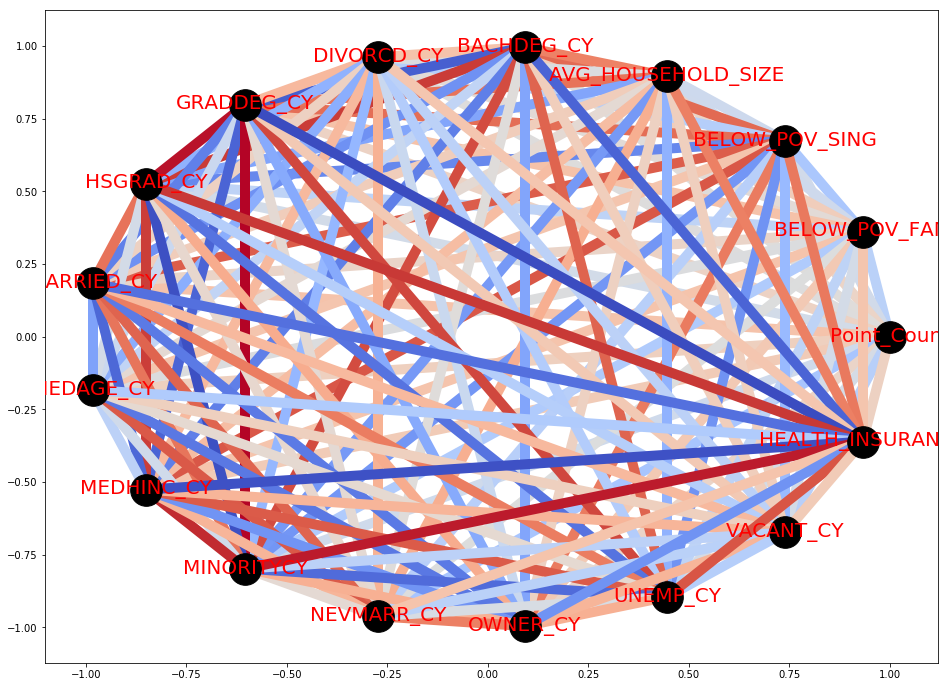

In [250]:
dataset_structure.visualize_full_graph()

#### Maximal pairwise interactions
The above graph is very dense, making it hard to pick out the most relevent variables. We can choose to visualize a relevence graph, which shows only the connections that have mutual information within some threshhold of the maximum observed value. In this example, we visualize only mutual information that is at least 80% of the maximum value. The colors in this graph have been re-normalized.

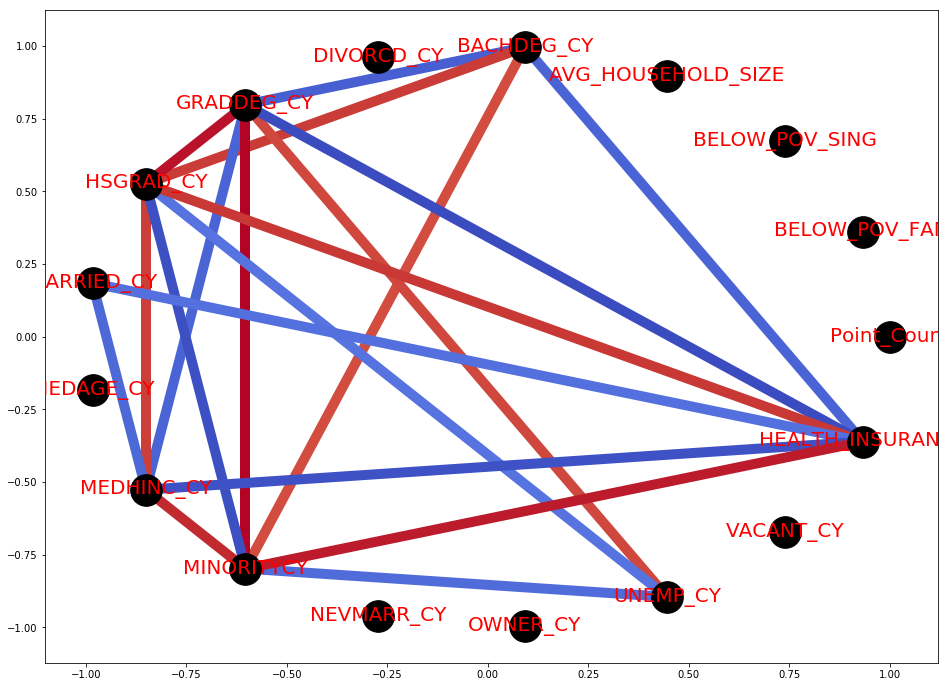

In [251]:
dataset_structure.visualize_relevence_graph(threshhold = 0.80)

#### Maximum spanning tree
While the above graph is a useful presentation of which variables have the strongest correlation, not every variable is included. For example, in the above graph, the variable Point_Count represents the number of crime indidents per captia in each voting precint. It is not connected in the sparse graph. If it were the variable of interest, you may like to at least see which variable it had the strongest correlation with. 

Learning a graph structure by computing the maximum spanning tree over pairwise mutual information is known as the Chow-Liu tree algorithm for structure learning. This is implemented by the following method.

In the resulting tree, each variable is connected to at least one other node in the graph. The stregnth of each connection (the pairwise mutual information) is again visualized by color, with darkest blue being the strongest connection.

Note that mutual information only shows which variables are correlated, not the direction of correlation (positive, negative, non-linear). 

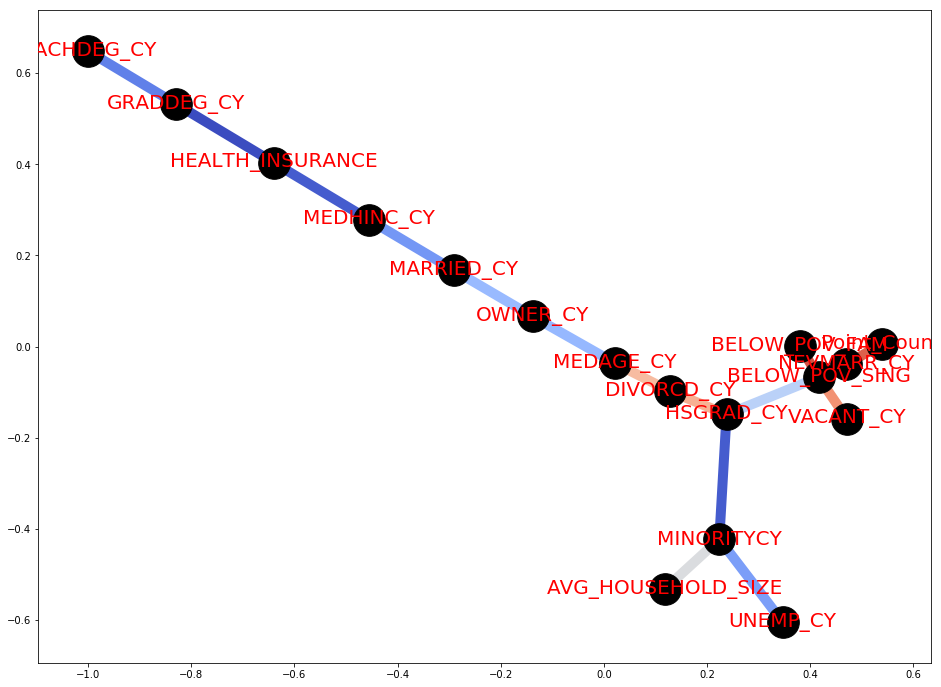

In [252]:
dataset_structure.visualize_maximum_spanning_tree(layout='kamada')

#### Visualizing Scatter Plots
To explore the results from the above analysis, we then plot the data for each of the variables identifed as having strong pairwise mutual information. 

For example, MEDHINC_CY (Median Houshold income) and HEALTH_INSURANCE (Average costs of healthcare in the precint) have the highest mutual information score and the scatter plot shows they have a strong postivie linear trend. Alternatively, GRADDEG_CY (Averger number of people with graduate degreees in the precint) and MINORITYCY (Proportion of the population recognized as a minority) has a strong negative linear trend. 

Note thhat when the flag 'use_analysis_vars' is set to true, the scatter plots display the binned data normalized by population that is used to compute mutual information. The 'top_n' input specifies how many of the top mutual information plots to show. If it is omitted, the scatter plots for the entire dataset are shown. 

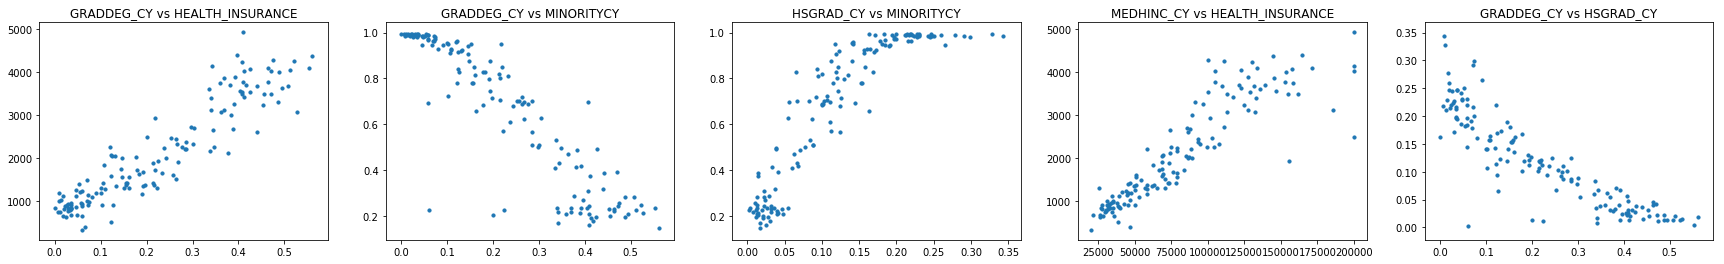

In [253]:
importlib.reload(sl)
dataset_structure.visualize_scatter_plots(top_n = 5, shape=(1,5), use_analysis_vars=True)

We can also visualize variables identified as having weak or low mutual information. For example, the variables UNEMP_CY (or unemployment rate) and BELOW_POV_FAM (proportion of families below the poverty level) have a low mutual information score in the graph above. This may be somewhat suprising, as these are related concepts.  However, when you plot the data, there is not obvious trend between the two variables, confirming the mutual information results.

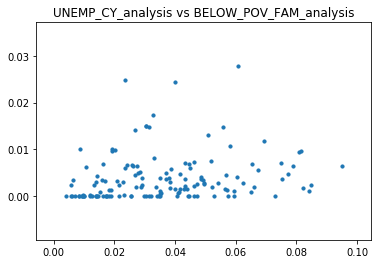

In [234]:
dataset_structure.compare_variables('UNEMP_CY', 'BELOW_POV_FAM', use_analysis_vars=True)

Finally, the pairwise plot of every attibute in the dataset can be visualized by omitting the top_n flag. Although this is too dense to parse easily, it is also useful for observing trends.

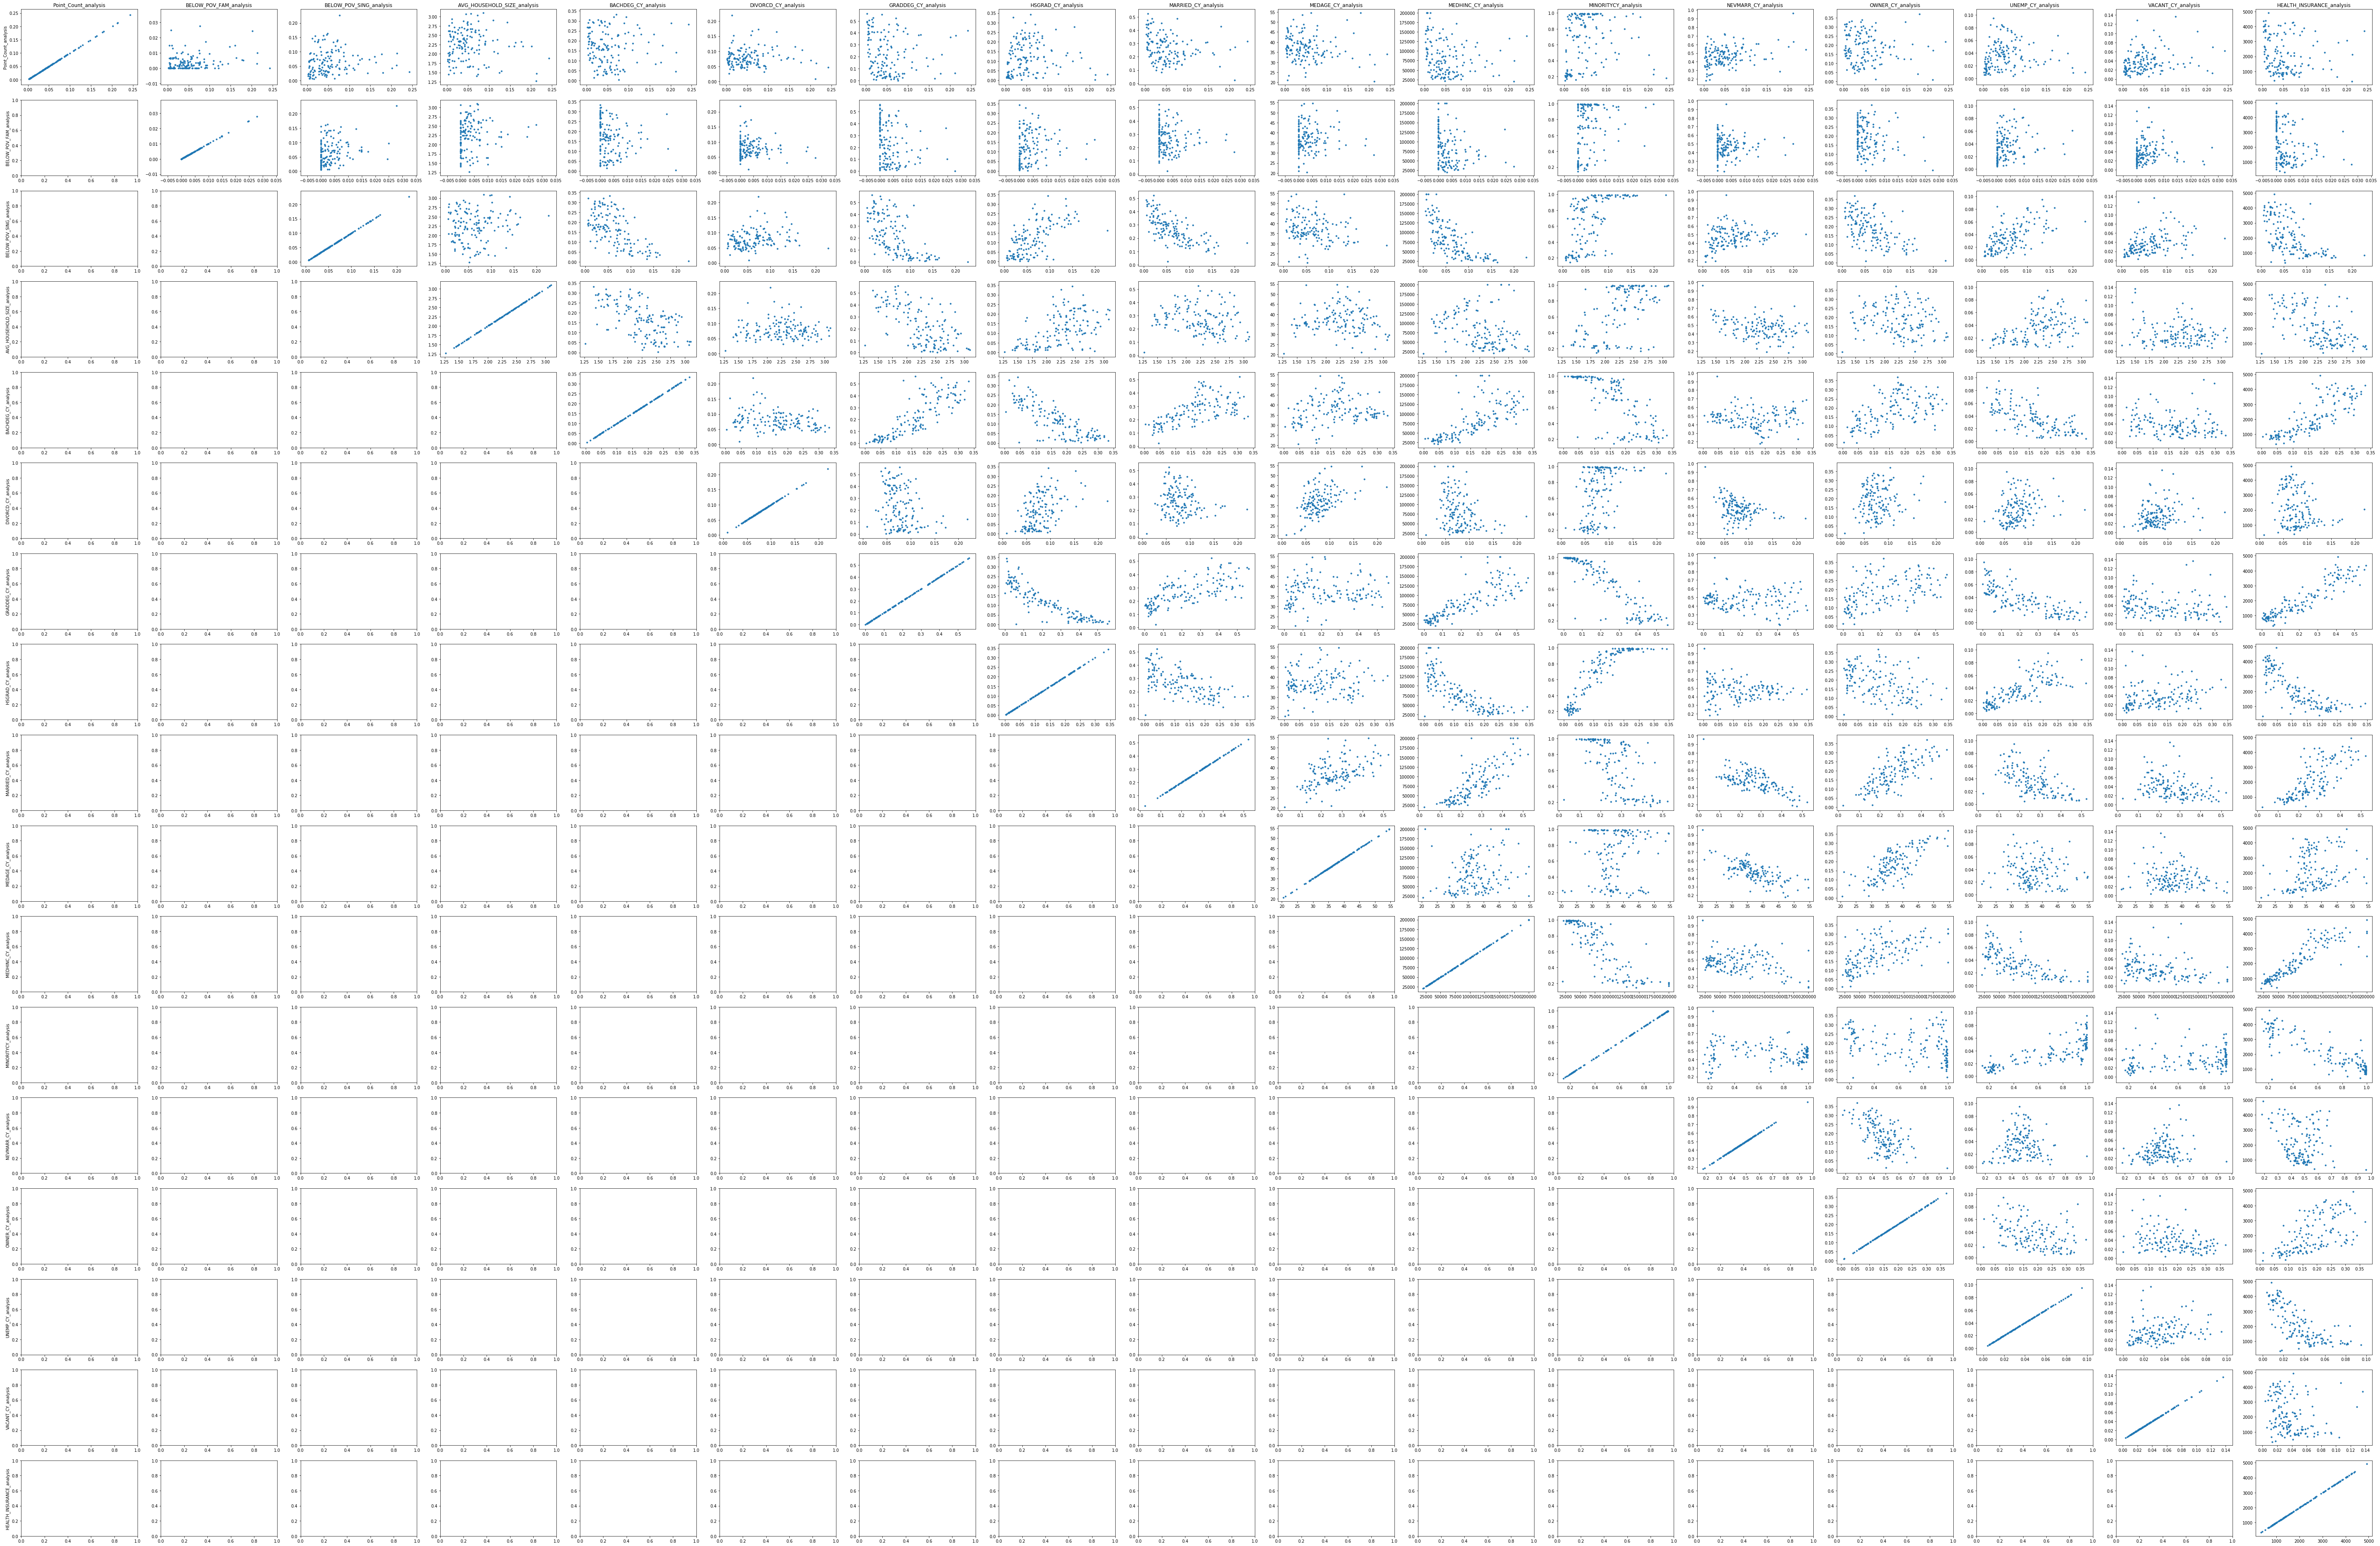

In [235]:
dataset_structure.visualize_scatter_plots(use_analysis_vars=True)

#### Visualizing the results via ArcGIS Online API for python
Now that we have identified which attributes in the origional ArcGIS layers have strong correlation or mutual information, we can plot these layers on a map and inspect them visually. The strongest correlation was found between median income and average healthcare spending. We willl plot these two layers from the origonal dataset, aggregated over voting precints. By visual inspection, it is clear that there is a strong positive correlation between the two attributes.

In [ ]:
# Create a map of DC for visualiziation
dc_map = gis.map('Washington D.C.')
dc_map

![alt text](health_care_dc.png "Title")

In [ ]:
# Add the layer containing the average healthcare spending attribute
enriched_vote_block_layer = enriched_vote_block.layers[0]
dc_map.remove_layers()
dc_map.add_layer(enriched_vote_block_layer, {"renderer": "ClassedColorRenderer", 
                                             "field_name": "X8002_X",
                                             "opacity": 0.7})

In [ ]:
# Create a map of DC for visualiziation
dc_map2 = gis.map('Washington D.C.')
dc_map2

![alt text](med_income_dc.png "Title")

In [ ]:
dc_map2.add_layer(enriched_vote_block_layer, {"renderer": "ClassedColorRenderer", 
                                             "field_name": "MEDHINC_CY",
                                             "opacity": 0.7})

In [ ]:
# Print the list of attributes that can be visualized
for field in enriched_vote_block_layer.properties['fields']:
    print(field['name'])

In [ ]:
# Old Workflow 
# enriched_data_df = GeoAccessor.from_layer(enriched_vote_block.layers[0])
# crime_data_df = GeoAccessor.from_layer(crime_raw_vote_block.layers[0])
# full_data_df = GeoAccessor.from_featureclass(full_data_layer.layer)
# Make voting precint name the index for each data frame
# enriched_data_df.set_index('OBJECTID', drop = True, append = False, inplace = True)
# crime_data_df.set_index('OBJECTID', drop = True, append = False, inplace = True)
# Join voter predcint enriched data with crime data (inner join by precint name)
# full_data_df = enriched_data_df.join(crime_data_df, how='inner', lsuffix='_enriched', sort=True)
# full_data_df = enriched_data_df.join(crime_data_df[['Point_Count']], how='inner', lsuffix='_enriched', sort=False)
# full_data_df = enriched_data_df.join(crime_data_df[['Point_Count']], how='left')

# Clean up data by removing non-data columns
# full_data_df.drop(labels = ['WEB_URL', 
#                             'WEB_URL_enriched', 
#                             'SHAPE_enriched', 
#                             'SHAPE_Leng_enriched', 
#                             'OBJECTID_enriched',
#                             'OBJECTID',
#                             'OBJECTID_1_enriched',
#                             'OBJECTID_1',
#                             'OBJECTID_12_enriched',
#                             'OBJECTID_12',
#                             'apportionmentConfidence'],
#                      axis = 'columns', 
#                      inplace = True)

# Join via ArcGIS Online
# full_data_layer = join_features(target_layer = enriched_vote_block.layers[0],
#                                 join_layer = crime_raw_vote_block.layers[0],
#                                 spatial_relationship = 'intersects')

# full_data_features = full_data_layer.query()
# full_data_df = full_data_features.sdf

# Import voting precinct enriched data and crime data for the DC area
# enriched_data_df = pd.DataFrame.spatial.from_layer(enriched_vote_block.layers[0])
# crime_data_df = pd.DataFrame.spatial.from_layer(crime_raw_vote_block.layers[0])

# # Join via Pandas
# full_data_df = enriched_data_df.join(crime_data_df[['Point_Count']], how='inner', lsuffix='_enriched', sort=False)

# Doesn't currenly work, but would be nice to convert sdf back into a arcgis layer for visaulization
# full_data_fc = gis.content.import_data(full_data_df)
# for field in full_data_fc.layers[0].properties['fields']:
#     print(field['name'])

# Join via ArcGIS Online
# full_data_layer = join_features(target_layer = enriched_vote_block.layers[0],
#                                 join_layer = crime_raw_vote_block.layers[0],
#                                 spatial_relationship = 'intersects',
#                                 output_name = 'join_demo_crime_dc_voting_precint')

# full_data_features = full_data_layer.query()
# full_data_df = full_data_features.sdf